In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from typing import List

In [2]:
# load data, split
train_dev = pd.read_csv("data/downloaded/twitter-train-clean.tsv", names=["label","text"],encoding="utf-8",sep='\t').dropna()
# train, dev = train_test_split(train_dev, test_size=0.2)
test = pd.read_csv("data/downloaded/twitter-test-clean.tsv", names=["label","text"],encoding="utf-8",sep='\t').dropna()

In [ ]:
# load data, split
train_dev = pd.read_csv("data/downloaded/twitter-train-clean.tsv", names=["label","text"],encoding="utf-8",sep='\t').dropna()
# train, dev = train_test_split(train_dev, test_size=0.2)
test = pd.read_csv("data/downloaded/twitter-test-clean.tsv", names=["label","text"],encoding="utf-8",sep='\t').dropna()

In [33]:
def map_label(label):
    if label == "negative":
        return 0
    elif label =="neutral":
        return 1
    elif label =="positive":
        return 2

X_train_dev = train_dev.text.to_list()
y_train_dev = train_dev.label.apply(lambda x: map_label(x)).to_list()
# X_dev = dev.text.to_list()
# y_dev = dev.label.apply(lambda x: map_label(x)).to_list()
X_test = test.text.to_list()
y_test = test.label.apply(lambda x: map_label(x)).to_list()

In [42]:
# tf idf tokenization
# tokenizing
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer(binary=True)
X_train_tfidf = tf_idf.fit_transform(X_train_dev)
# X_dev_tfidf = tf_idf.fit_tra?nsform(X_dev)

In [35]:
X_train_tfidf.shape

(40296, 38021)

In [36]:
from sklearn.linear_model import SGDClassifier
from scipy.sparse import csr_matrix 

In [43]:
def train_model(X: csr_matrix, y: List) -> None:
    X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.2)
    clf = SGDClassifier()
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    dev_score= clf.score(X_dev, y_dev)
    print(f'Train score: {round(train_score,2)}, Dev score: {round(dev_score, 2)}')


In [44]:
train_model(X_train_tfidf, y_train_dev)

Train score: 0.73, Dev score: 0.66


<h1> TODO </h1>
<p> FIND OWN PARAM RANGE</p>

In [40]:
# hyperparam tuning

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform


# Phase 1: loss, learning rate and initial learning rate

clf = SGDClassifier()

distributions = dict(
    loss=['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
    learning_rate=['optimal', 'invscaling', 'adaptive'],
    eta0=uniform(loc=1e-7, scale=1e-2)
)

random_search_cv = RandomizedSearchCV(
    estimator=clf,
    param_distributions=distributions,
    cv=5,
    n_iter=50
)
random_search_cv.fit(X_train_tfidf, y_train_dev)
print(f'Best params: {random_search_cv.best_params_}')
print(f'Best score: {random_search_cv.best_score_}')

/Users/juliawasala/miniconda3/envs/tmprojectenv/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/juliawasala/miniconda3/envs/tmprojectenv/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/juliawasala/miniconda3/envs/tmprojectenv/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/juliawasala/miniconda3/envs/tmprojectenv/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before converg

Best params: {'eta0': 0.007651751887061383, 'learning_rate': 'optimal', 'loss': 'hinge'}
Best score: 0.6311542233349149


In [45]:
sgd_classifier = random_search_cv.best_estimator_

print(sgd_classifier.score(tf_idf.transform(X_test), y_test))

0.5035590807402888


In [52]:
from sklearn.metrics import confusion_matrix

reverse_map = {0: "negative", 1:"neutral",2:"positive"}


confusion_matrix(y_test, sgd_classifier.predict(tf_idf.transform(X_test)))
df_confusion=pd.crosstab(pd.Series([reverse_map[i] for i in y_test], name = "True"), pd.Series([reverse_map[i] for i in sgd_classifier.predict(tf_idf.transform(X_test))], name = "Predicted"), margins=True)

In [53]:
df_confusion

Predicted,negative,neutral,positive,All
True,,,,
negative,213,1137,216,1566
neutral,137,2818,473,3428
positive,61,2858,1921,4840
All,411,6813,2610,9834


In [46]:
import pickle
with open('baseline.pkl','wb') as f:
    pickle.dump(sgd_classifier,f)

In [54]:
import seaborn as sns

<AxesSubplot:xlabel='Predicted', ylabel='True'>

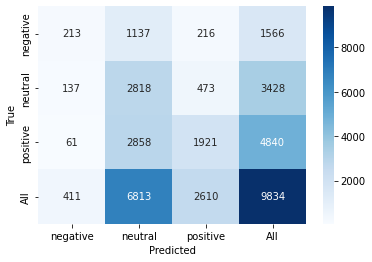

In [56]:
sns.heatmap(df_confusion, annot=True,fmt='g',cmap='Blues')